# Linear & Random Forest models on a few features

Build a linear model on autompg data using basic features, then add Random Forest.

We see that we have a basic but useful $r^2$ score using several features.

In [1]:
import numpy as np
import pandas as pd

import altair as alt
alt.renderers.enable('notebook')

from yellowbrick.regressor import ResidualsPlot
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, RegressorMixin, MultiOutputMixin
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline

RANDOM_STATE = 0

df = pd.read_csv("autompg.csv")
df = df.dropna()
df.head()

,mpg,cylinders,displacement,hp,weight,acceleration,year,territory,carname
0,18.0,8.0,307.0,130.0,3504.0,12.0,1970,USA,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,1970,USA,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,1970,USA,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,1970,USA,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,1970,USA,ford torino


## Correlation will give us good predictors to explore

In [2]:
df.corr()['mpg'].sort_values()

weight         -0.832244
displacement   -0.805127
hp             -0.778427
cylinders      -0.777618
acceleration    0.423329
year            0.580541
mpg             1.000000
Name: mpg, dtype: float64

## Consider Altair for interactive exploration

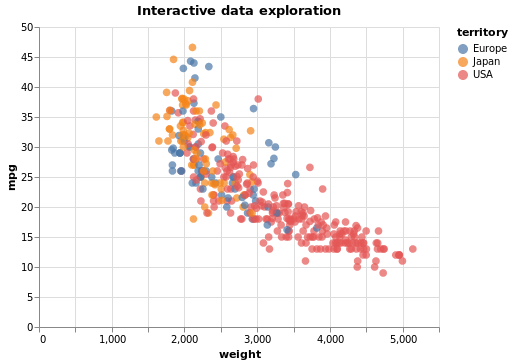

In [3]:
alt.Chart(df, title='Interactive data exploration').mark_circle(size=60).encode(
    x='weight',
    y='mpg',
    #color='year',
    color='territory',
    tooltip=['carname', 'year', 'territory']).interactive()

## I choose to continue with matplotlib due to recent ipyvega issues!

## Let's consider - we have a sceptical colleague

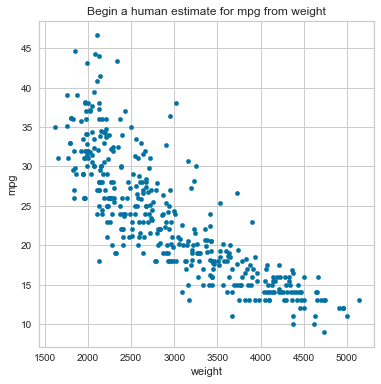

In [4]:
fig, ax = plt.subplots(figsize = (6, 6))
df.plot(kind='scatter', x='weight', y='mpg', c='b', ax=ax)
ax.set_title('Begin a human estimate for mpg from weight');

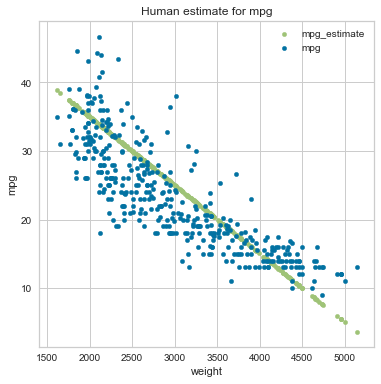

In [5]:
WEIGHT_TO_MPG = 0.01 # estimate from colleague
df['mpg_estimate'] = (df.weight * -WEIGHT_TO_MPG) + 55

def plot_estimates(df, src, y='mpg_estimate'):
    fig, ax = plt.subplots(figsize = (6, 6))
    df.plot(kind='scatter', x='weight', y=y, c='g', ax=ax, label=y);
    df.plot(kind='scatter', x='weight', y='mpg', c='b', ax=ax, label='mpg')
    ax.set_title(f'{src} for mpg');
    ax.legend();
    
plot_estimates(df, src='Human estimate')

In [6]:
features = ['weight']
X_train, X_test, y_train, y_test = train_test_split(df[features], df.mpg, random_state=RANDOM_STATE)

In [7]:
class MyEstimator(BaseEstimator, RegressorMixin, MultiOutputMixin):
    _estimator_type = "regressor"

    def fit(self, X_train, y_train):
        pass
    
    def predict(self, X):
        y = (X.values[:, 0] * -0.01) + 55
        return y

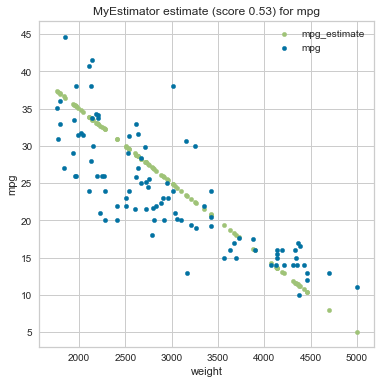

In [8]:
my_est = MyEstimator()

df2 = pd.DataFrame({'mpg': y_test, 'weight': X_test.weight})
my_est.fit(X_train, y_train)
df2['mpg_estimate'] = my_est.predict(X_test)

from sklearn.metrics import r2_score
score = r2_score(y_test, my_est.predict(X_test))
plot_estimates(df2, src=f'MyEstimator estimate (score {score:0.2f})')

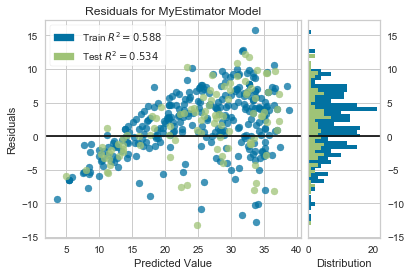

In [9]:
visualizer = ResidualsPlot(my_est) # yellowbrick

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()         

## LinearRegression model

Coefficient: -0.008, offset 46.41


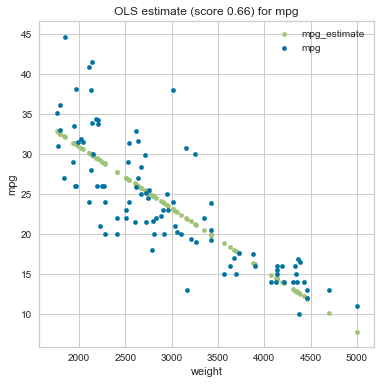

In [10]:
ols = LinearRegression()
ols.fit(X_train, y_train)

df2['mpg_estimate'] = ols.predict(X_test)

score = r2_score(y_test, ols.predict(X_test))
print(f"Coefficient: {ols.coef_[0]:0.3f}, offset {ols.intercept_:0.2f}")
plot_estimates(df2, src=f'OLS estimate (score {score:0.2f})')

## Move to a more sophisticated RandomForest with more features

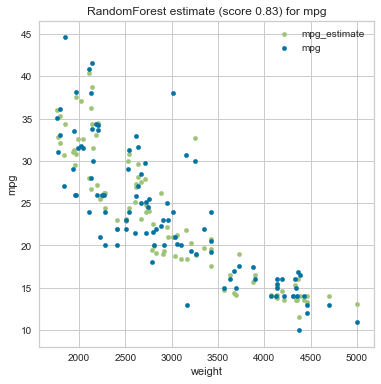

In [11]:
features = ['weight', 'hp', 'cylinders', 'acceleration', 'year']
X_train, X_test, y_train, y_test = train_test_split(df[features], df.mpg, random_state=RANDOM_STATE)

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

df2['mpg_estimate'] = rf.predict(X_test)
score = r2_score(y_test, rf.predict(X_test))
plot_estimates(df2, src=f'RandomForest estimate (score {score:0.2f})')

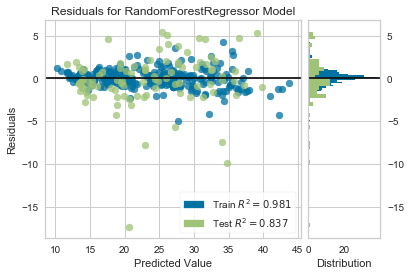

In [12]:
visualizer = ResidualsPlot(rf)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()         

# Build an interactive predictor with Widgets...

In [13]:
caption = widgets.Label(value='Predicted MPG: ...')
slider = widgets.FloatSlider(min=1613, max=5140, value=3000, description='weight')

def handle_slider_change(change):
    # features = ['weight', 'hp', 'cylinders', 'acceleration', 'year']
    row = np.array([change.new, 130, 8, 13, 1970])
    predicted_mpg = rf.predict([row])
    caption.value = f'Predicted MPG: {predicted_mpg[0]}'  
    

slider.observe(handle_slider_change, names='value')
display(caption, slider)

Label(value='Predicted MPG: ...')

FloatSlider(value=3000.0, description='weight', max=5140.0, min=1613.0)